# Практическая работа №2: Корреляционный и регрессионный анализ
Выполнил студент гр. 0373 Савинов Алексей. Вариант №18

## Цель работы
Освоение основных понятий, связанных с корреляционной зависимостью между случайными величинами, статистическими гипотезами и проверкой их «справедливости». Ознакомление с основными положениями метода наименьших квадратов (МНК), со статистическими свойствами МНК оценок, с понятием функции регрессии и роли МНК в регрессионном анализе, с корреляционным отношением, как мерой тесноты произвольной (в том числе и линейной) корреляционной связи.

## Основные теоретические положения

- Двумерный интервальный ряд показывает частоты одной величины в определенном интервале при условии принадлжености сопряженной величины другому интервалу для всех интервалов интервальных рядов первой и второй величины. Для проверки правильности подсчета частот в двумерном интервальном ряду
- Коэффициент корреляции: $$r_{xy} = {{{1 \over n} \Sigma_{i = 1}^{K_u} \Sigma_{j = 1}^{K_v} n_{uv} u_i v_j - \overline u \overline v} \over {\sigma_u \sigma_v}}, $$ где $u_{i} = \frac{x_i - C_x}{h_x}, v_j = \frac{y_j - C_y}{h_y}$
- Доверительный интервал для коэффициента корреляции: $z = \text{arth}(r_в)$, интервал для $z$: $(z - {t \over {\sqrt{n - 3}}}; z + {t \over {\sqrt{n - 3}}})$, где $n$ - количество элементов выборки $t$ - значение коэффициента стьюдента. $r_в$ принадлежит интервалу $(th(z_1); th(z_2))$
- Проверка статистической гипотезы о равенстве коэффициента корреляции нулю при заданном уровне значимости $\alpha$: $T_{набл} = {r_в \frac{\sqrt{n - 2}}{\sqrt{1 - r_в^2}}}$, $T_{крит} = {t(\alpha, df)}$, где $df = n - 2$. Условие принятия гипотезы: $|T_{набл}| < T_{крит}$
- уравнение средней квадратичной регрессии x на y: $F(a, b, c) = \sum_{i=1}^{n}{(a+bx_i+cx_i^2-y_i)^2} \rightarrow min$

## Постановка задачи
Из заданной генеральной совокупности сформировать выборку по второму признаку. Для системы двух случайных величин $X$ (первый признак) и $Y$ (второй признак) сформировать двумерную выборку и найти статистическую оценку коэффициента корреляции, построить доверительный интервал для коэффициента корреляции и осуществить проверку статистической гипотезы о равенстве коэффициента корреляции нулю. Построить уравнения выборочных прямых среднеквадратической регрессии. Полученные линейные функции регрессии отобразить графически. Найти выборочное корреляционное отношение. Оценить адекватность моделей. Полученные результаты содержательно проинтерпретировать.

## Выполнение работы

In [1]:
import numpy as np
import pandas as pd
from pandas import option_context
import scipy.stats
import math
import matplotlib.pyplot as plt
from IPython.display import HTML, Math

In [2]:
disp_pres = 2
pd.set_option(f'display.float_format', f'{{:.{disp_pres}f}}'.format)

In [3]:
def tex_format(array, tag):
    nparray = np.array(array)
    start_item = '$$\\' + tag + '{'
    start = np.full((len(nparray)), '$$\\' + tag + '{')
    finish = np.full((len(nparray)), '}$$')
    return np.core.defchararray.add(
        np.core.defchararray.add(start, nparray.astype(str)),
        finish
    )

In [4]:
def get_sample(path_to_sample, column):
    return pd.read_csv(path_to_sample)[column].to_numpy()

def get_inter_k(sample):
    return round(np.log2(len(sample))) + 1

def get_inter_h(sample):
    samp_uniq = np.array(np.unique(sample, return_counts=True))
    return (np.max(samp_uniq[0]) - np.min(samp_uniq[0])) / \
    get_inter_k(sample)
    
def get_inter_bounds(sample):
    return np.linspace(np.min(sample), 
                       np.max(sample), get_inter_k(sample)+1)

def get_inter_means(sample):
    inter_bounds = get_inter_bounds(sample)
    return np.array([(inter_bounds[i+1]+inter_bounds[i])/2 
                     for i in range(len(inter_bounds)-1)])

def get_inter_counts(sample):
    samp_uniq = np.array(np.unique(sample, return_counts=True))
    inter_bounds = get_inter_bounds(sample)
    inter_counts = np.array([np.count_nonzero(
        np.logical_and(samp_uniq[0] > inter_bounds[i],
                       samp_uniq[0] <= inter_bounds[i+1])
    ) for i in range(len(inter_bounds)-1)])
    inter_counts[0] += 1
    return inter_counts

def get_inter_freqs(sample):
    return get_inter_counts(sample) / len(sample)

def get_inter_counts_cum(sample):
    return np.cumsum(get_inter_counts(sample))

def get_inter_freqs_cum(sample):
    return np.cumsum(get_inter_freqs(sample))

#---------Условное---------#

def get_fict_zero(sample):
    inter_bounds = get_inter_bounds(sample)
    inter_means = get_inter_means(sample)
    inter_counts = get_inter_counts(sample)
    # найдем ложный нуль
    num_inters = len(inter_bounds) - 1
    fict_zero = None
    # один средний интервал
    if num_inters % 2 != 0:
        fict_zero = inter_means[num_inters // 2]
    # два средних интервала
    else:
        fict_zero = inter_means[num_inters // 2 - 1] if \
            inter_counts[num_inters // 2 - 1] >= inter_counts[num_inters // 2] \
            else inter_means[num_inters // 2]
    return fict_zero

def get_cond_variant(sample):
    return np.round((get_inter_means(sample) - get_fict_zero(sample)) / \
        get_inter_h(sample)).astype(np.int64)

def get_n_mul_u_pow_lower_k(sample, k):
    inter_counts = get_inter_counts(sample)
    cond_variant = get_cond_variant(sample)
    return np.array([inter_counts * cond_variant ** i 
                         for i in range(k)])

def get_n_mul_u_1_pow_4():
    inter_counts = get_inter_counts(sample)
    cond_variant = get_cond_variant(sample)
    return np.multiply(np.power(cond_variant+1, 4), inter_counts)

def get_nu_pow_lower_k(sample, k):
    inter_counts = get_inter_counts(sample)
    cond_variant = get_cond_variant(sample)
    return np.array([np.sum(inter_counts * cond_variant ** i) / len(sample)
                     for i in range(k)])

def get_mu_pow_lower_4(sample):
    inter_h = get_inter_h(sample)
    nu = get_nu_pow_lower_k(sample, 5)
    nu = nu[1:]
    mu = np.zeros((4))
    mu[0] = 0
    mu[1] = (nu[1] - nu[0] ** 2) * inter_h ** 2
    mu[2] = (nu[2] - 3 * nu[1] * nu[0] + 2 * nu[0] ** 3) * inter_h ** 3
    mu[3] = (nu[3] - 4 * nu[2] * nu[0] + 6 * nu[1] * nu[0] ** 2 - 
             3 * nu[0] ** 4) * inter_h ** 4
    return mu

def get_mean(sample):
    return np.sum(sample) / len(sample)

def get_cond_v_mean(sample):
    inter_h = get_inter_h(sample)
    nu = get_nu_pow_lower_k(sample, 2)
    nu = nu[1:]
    fict_zero = get_fict_zero(sample)
    return nu[0] * inter_h + fict_zero

def get_var(sample):
    samp_mean = get_mean(sample)
    return np.sum((sample - samp_mean) ** 2) / len(sample)

def get_cond_v_var(sample):
    mu = get_mu_pow_lower_4(sample)
    return mu[1]

def get_std(sample):
    return np.sqrt(get_var(sample))

def get_corr_var(sample):
    samp_var = get_var(sample)
    return len(sample) / (len(sample) - 1) * samp_var

def get_corr_std(sample):
    return np.sqrt(get_corr_var(sample))

def get_skew(sample):
    mu = get_mu_pow_lower_4(sample)
    return mu[2] / np.sqrt(mu[1]) ** 3

def get_kurt(sample):
    mu = get_mu_pow_lower_4(sample)
    return mu[3] / mu[1] ** 2 - 3

# функция, которая склеивает два соседних интервала по указанному индексу,
# и склеивает соседние пары интервалов рядом с ними, если можно
def __join_inters(inter_counts, inter_bounds, idx, fir_inter_max):
    assert len(inter_counts) == len(inter_bounds) - 1
    assert idx >= 0 and idx < len(inter_counts) - 1
    inter_counts_ext = np.copy(inter_counts)
    inter_bounds_ext = np.copy(inter_bounds)
    # убираем границу
    inter_bounds_ext = np.delete(inter_bounds_ext, idx+1)
    # склеиваем частоты
    inter_counts_ext[idx] += inter_counts_ext[idx+1]
    # убираем частоту следующего интервала
    inter_counts_ext = np.delete(inter_counts_ext, idx+1)
    # объединяем соседние интервалы по возможности
    # левые два
    if idx - 2 >= 0 and \
    inter_counts_ext[idx-1] < fir_inter_max and \
    inter_counts_ext[idx-2] < fir_inter_max:
        inter_bounds_ext = np.delete(inter_bounds_ext, idx-1)
        inter_counts_ext[idx-2] += inter_counts_ext[idx-1]
        inter_counts_ext = np.delete(inter_counts_ext, idx-1)
        idx -= 1
    # правые два
    if idx + 2 < len(inter_counts_ext) and \
    inter_counts_ext[idx+1] < fir_inter_max and \
    inter_counts_ext[idx+2] < fir_inter_max:
        inter_bounds_ext = np.delete(inter_bounds_ext, idx+2)
        inter_counts_ext[idx+1] += inter_counts_ext[idx+2]
        inter_counts_ext = np.delete(inter_counts_ext, idx+2)
    return inter_counts_ext, inter_bounds_ext

# функция, объединяющая интервалы соседние модальные интервалы, и 
# близлежащие, по возможности
def __join_mode_inters(inter_counts, inter_bounds):
    assert len(inter_counts) == len(inter_bounds) - 1
    inter_counts_ext = np.copy(inter_counts)
    inter_bounds_ext = np.copy(inter_bounds)
    # будем склеивать модальные интервалы, пока 
    # существуют соседние модальные интервалы
    fir_inter_max = np.max(inter_counts_ext)
    while len(np.argwhere(inter_counts_ext == fir_inter_max)) != 0:
        mode_inters = np.concatenate(
            np.argwhere(inter_counts_ext == fir_inter_max))
        adj_mode_inters_idx = -1
        for i in range(len(mode_inters)-1):
            print(mode_inters[i], mode_inters[i+1] - 1, mode_inters[i] == mode_inters[i+1] - 1)
            if mode_inters[i] == mode_inters[i+1] - 1:
                adj_mode_inters_idx = mode_inters[i]
                break
        if adj_mode_inters_idx == -1:
            break
        # если соседние модальные интервалы существуют, объединим
        else:
            inter_counts_ext, inter_bounds_ext = __join_inters(
                inter_counts_ext, inter_bounds_ext, 
                adj_mode_inters_idx, fir_inter_max
            )
            
    return inter_counts_ext, inter_bounds_ext, fir_inter_max

# функция для подсчета моды заданного интервала
def __count_inter_mode(inter_counts, inter_bounds, inter_h, idx):
    assert len(inter_counts) == len(inter_bounds) - 1
    assert idx >= 0 and idx < len(inter_counts) - 1
    inter_counts_ext = np.concatenate(([0], inter_counts, [0]))
    idx += 1
    return inter_bounds[idx-1] + \
        (inter_counts_ext[idx] - inter_counts_ext[idx-1]) / \
        (inter_counts_ext[idx] - inter_counts_ext[idx-1] + \
         inter_counts_ext[idx] - inter_counts_ext[idx+1]) * inter_h

def get_inter_mode(sample):
    inter_counts = get_inter_counts(sample)
    inter_bounds = get_inter_bounds(sample)
    inter_h = get_inter_h(sample)
    inter_counts_ext = np.copy(inter_counts)
    inter_counts_ext, inter_bounds_ext, fir_inter_max = __join_mode_inters(
        inter_counts_ext, inter_bounds)

    return [__count_inter_mode(inter_counts, inter_bounds, inter_h, i) \
            for i in np.concatenate(np.argwhere(inter_counts_ext >= fir_inter_max))]
    
def get_inter_median(sample):
    samp_median = None
    med_idx = np.where(inter_freqs_cum >= 0.5)[0][0]
    if med_idx == 0:
        samp_median = inter_bounds[med_idx] + (0.5 * len(sample)) / \
            inter_counts_cum[med_idx]
    else:
        samp_median = inter_bounds[med_idx] + (0.5 * len(sample) - \
            inter_counts_cum[med_idx-1]) / inter_counts_cum[med_idx]
    return samp_median

def get_cv(sample):
    samp_var = get_var(sample)
    samp_mean = get_mean(sample)
    return np.sqrt(samp_var) / np.abs(samp_mean)

def get_mean_conf_inter(sample, conf):
    samp_std = get_std(sample)
    t = scipy.stats.t.ppf(conf, len(sample)-1)
    return [samp_mean - t * samp_std / np.sqrt(len(sample)), 
            samp_mean + t * samp_std / np.sqrt(len(sample))]
    
def get_mean_accuracy(sample, conf):
    samp_std = get_std(sample)
    t = scipy.stats.t.ppf(conf, len(sample)-1)
    return t * samp_std / np.sqrt(len(sample))

def get_std_conf_inter95(sample):
    corr_samp_std = get_corr_std(sample)
    q95 = 0.151
    return [corr_samp_std * (1 - q95), corr_samp_std * (1 + q95)]

def get_std_conf_inter99(sample):
    corr_samp_std = get_corr_std(sample)
    q99 = 0.211
    return [corr_samp_std * (1 - q99), corr_samp_std * (1 + q99)]

#def get_something_for_Pirson():


### Провести статистическую обработку второй выборки в объеме практической работы №1 с целью определения точечных статистических оценок параметров распределения исследуемого признака (математического ожидания, дисперсии, среднеквадратичного отклонения, асимметрии, эксцесса, моды, медианы и коэффициента вариации). Оформить результаты в виде таблиц, сделать выводы.

Вторая выборка представлена во <u>втором столбце</u> таблицы в файле _"Данные для практических работ.csv"_. Выборка является бесповторной, по способу формирования - типическая (где тип - гражданство).

In [5]:
y_sample = get_sample('Данные для практических работ.csv', 
                      'Численность женщин')
print('Выборка:\n', y_sample)

Выборка:
 [ 924306  915922  917727  868828  809866  820290  818433  772989  713837
  719139  720495  712570  688668  645391  659500  623163  651089  633067
  667056  709940  740493  758535  881232  975986 1127972 1155172 1210745
 1265138 1261487 1255017 1219410 1245468 1175050 1121621 1196106 1104835
 1105328 1076185 1086397 1101834 1056631 1026951 1031590  991874 1028176
  931599  921577  910541  946795 1003079 1029062 1105474 1155471 1213086
 1304369 1228833 1229446 1198493 1164946 1178109 1173482 1059852 1071195
 1029035 1016786 1030393  845857  821262  734024  447156  333510  305713
  458623  708253  751953  807743  789619  763019  592371  496221  365276
  335378  379352  347099  356954  315216  293598  233256  192420  146563]


In [6]:
inter_bounds = get_inter_bounds(y_sample)
inter_means = get_inter_means(y_sample)
inter_counts = get_inter_counts(y_sample)
inter_freqs = get_inter_freqs(y_sample)
inter_counts_cum = get_inter_counts_cum(y_sample)
inter_freqs_cum = get_inter_freqs_cum(y_sample)
intervals = [f'({np.round(inter_bounds[i], disp_pres)}; {np.round(inter_bounds[i+1], disp_pres)}]' 
             for i in range(len(inter_bounds)-1)]
intervals[0] = '[' + intervals[0][1:]

tab1_1 = pd.DataFrame(
    {
        '$$i$$': np.append(
            np.arange(1, len(intervals)+1).astype(str),
            '$$\Sigma$$'
        ),
        '$$(y_{i-1}, y_i]$$': np.append(intervals, '$$-$$'),
        '$$\hat{y_i}$$': np.append(
            np.round(inter_means, disp_pres).astype(str),
            '$$-$$'
        ),
        '$$n_i$$': np.append(inter_counts, np.sum(inter_counts)),
        '$$p_i^*$$': np.append(inter_freqs, np.sum(inter_freqs)),
        '$$n_i^{\Sigma}$$': np.append(inter_counts_cum.astype(str), '$$-$$'),
        '$$p_i^{\Sigma}$$': np.append(
            np.round(inter_freqs_cum, disp_pres).astype(str),
            '$$-$$'
        )
    }
)
display(HTML(tab1_1.to_html(index=False)))

tab1_2 = pd.DataFrame(
    {
        'Характеритика': 'Значение',
        '$$\widetilde{y_в}$$':  np.round(get_cond_v_mean(y_sample), 
                                         disp_pres).astype(str),
        '$$\sigma_y^2$$': np.round(get_cond_v_var(y_sample), 
                                         disp_pres).astype(str),
        '$$\sigma_y$$': np.round(get_std(y_sample), 
                                 disp_pres).astype(str),
        '$$s_y^2$$': np.round(get_corr_var(y_sample), 
                               disp_pres).astype(str),
        '$$s_y$$': np.round(get_corr_std(y_sample), 
                             disp_pres).astype(str),
        '$$a_s^*$$': np.round(get_skew(y_sample), 
                              disp_pres).astype(str),
        '$$\epsilon_k^*$$': np.round(get_kurt(y_sample), 
                                     disp_pres).astype(str),
        '$$M_o^*$$': np.round(get_inter_mode(y_sample), 
                              disp_pres).astype(str),
        '$$M_e^*$$': np.round(get_inter_median(y_sample), 
                              disp_pres).astype(str),
        '$$V^*$$': (np.round(get_cv(y_sample), 
                             disp_pres)*100).astype(str) + '%',
    }
)
display(HTML(tab1_2.to_html(index=False)))

$$i$$,"$$(y_{i-1}, y_i]$$",$$\hat{y_i}$$,$$n_i$$,$$p_i^*$$,$$n_i^{\Sigma}$$,$$p_i^{\Sigma}$$
1,[146563.0; 311963.86],229263.43,5,0.06,5,0.06
2,(311963.86; 477364.71],394664.29,9,0.10,14,0.16
3,(477364.71; 642765.57],560065.14,4,0.04,18,0.2
4,(642765.57; 808166.43],725466.0,19,0.21,37,0.41
5,(808166.43; 973567.29],890866.86,14,0.16,51,0.57
6,(973567.29; 1138968.14],1056267.71,21,0.23,72,0.8
7,(1138968.14; 1304369.0],1221668.57,18,0.20,90,1.0
$$\Sigma$$,$$-$$,$$-$$,90,1.00,$$-$$,$$-$$


Характеритика,$$\widetilde{y_в}$$,$$\sigma_y^2$$,$$\sigma_y$$,$$s_y^2$$,$$s_y$$,$$a_s^*$$,$$\epsilon_k^*$$,$$M_o^*$$,$$M_e^*$$,$$V^*$$
Значение,859624.47,86871704368.48,298411.54,90050005794.97,300083.33,-0.56,-0.66,1089347.89,808166.59,35.0%


### Построить двумерный интервальный вариационный ряд, оформить в виде таблицы

In [7]:
# функция для получения двумерного интервального вариационного ряда
def get_2d_inter_counts(fir_sample, sec_sample):
    fir_bounds = get_inter_bounds(fir_sample)
    sec_bounds = get_inter_bounds(sec_sample)
    counts = np.array([[
        np.count_nonzero(
            np.logical_and(np.logical_and(fir_sample > fir_bounds[i],
                                          fir_sample <= fir_bounds[i+1]),
                           np.logical_and(sec_sample > sec_bounds[j],
                                          sec_sample <= sec_bounds[j+1])
                          )
        ) for i in range(len(fir_bounds)-1)
    ] for j in range(len(fir_bounds)-1)])
    #! найдем частоты при sec_sample[k] = sec_bounds[0]
    counts[0] += np.array([np.count_nonzero(
        np.logical_and(np.logical_and(fir_sample > fir_bounds[i],
                                      fir_sample <= fir_bounds[i+1]),
                       sec_sample == sec_bounds[0]
                      )
    ) for i in range(len(fir_bounds)-1)])
    counts[0, 0] += np.count_nonzero(
        np.logical_and(fir_sample == fir_bounds[0],
                       sec_sample == sec_bounds[0]
                      )
    )
    return counts

In [8]:
x_sample = get_sample('Данные для практических работ.csv', 
                      'Численность мужчин')

x_bounds = get_inter_bounds(x_sample)
y_bounds = get_inter_bounds(y_sample)
y_x_counts = get_2d_inter_counts(x_sample, y_sample)
# найдем суммы
x_sums = np.sum(y_x_counts, axis=0)
y_sums = np.sum(y_x_counts, axis=1)
# интервалы для x
x_intervals = [f'({np.round(x_bounds[i], disp_pres)}; {np.round(x_bounds[i+1], disp_pres)}]' 
               for i in range(len(x_bounds)-1)]
x_intervals[0] = '[' + x_intervals[0][1:]
# интервалы для y
y_intervals = [f'({np.round(y_bounds[i], disp_pres)}; {np.round(y_bounds[i+1], disp_pres)}]' 
               for i in range(len(y_bounds)-1)]
y_intervals[0] = '[' + y_intervals[0][1:]
y_intervals_tex = tex_format(y_intervals, 'textbf')

tab2_1_prev = np.vstack((*y_x_counts, x_sums))
dict2_1 = dict(zip(x_intervals, tab2_1_prev.T))
tab2_1 = pd.DataFrame(
    {
        '$$Y/X$$': np.append(y_intervals_tex, '$$n_x$$'),
    } |
    dict2_1 |
    {
        '$$n_y$$': np.append(
            np.round(y_sums, disp_pres).astype(str), 
            '$$n=$$' + np.round(np.sum(y_sums), disp_pres).astype(str)
        )
    }
)
display(HTML(tab2_1.to_html(index=False)))
display(Math(f'\\Sigma{{n_x}} = {np.sum(x_sums)}'))
display(Math(f'\\Sigma{{n_y}} = {np.sum(y_sums)}'))

$$Y/X$$,[31074.0; 212739.86],(212739.86; 394405.71],(394405.71; 576071.57],(576071.57; 757737.43],(757737.43; 939403.29],(939403.29; 1121069.14],(1121069.14; 1302735.0],$$n_y$$
$$\textbf{[146563.0; 311963.86]}$$,5,0,0,0,0,0,0,5
$$\textbf{(311963.86; 477364.71]}$$,7,2,0,0,0,0,0,9
$$\textbf{(477364.71; 642765.57]}$$,1,1,0,2,0,0,0,4
$$\textbf{(642765.57; 808166.43]}$$,0,5,1,10,3,0,0,19
$$\textbf{(808166.43; 973567.29]}$$,0,0,2,0,9,3,0,14
$$\textbf{(973567.29; 1138968.14]}$$,0,0,0,5,3,12,1,21
$$\textbf{(1138968.14; 1304369.0]}$$,0,0,0,0,3,6,9,18
$$n_x$$,13,8,3,17,18,21,10,$$n=$$90


<IPython.core.display.Math object>

<IPython.core.display.Math object>

### По полученному двумерному интервальному вариационному ряду сформировать условные варианты и по полученным условным вариантам построить корреляционную таблицу, сделать выводы

In [9]:
def get_U_V(fir_sample, sec_sample):
    fir_cond_variants = get_cond_variant(fir_sample)
    sec_cond_variants = get_cond_variant(sec_sample)
    counts = get_2d_inter_counts(fir_sample, sec_sample)
    U = np.sum(counts * fir_cond_variants, axis=1)
    V = np.sum(counts.T * sec_cond_variants, axis=1)
    return U, V

def get_uV_vU(fir_sample, sec_sample):
    fir_cond_variants = get_cond_variant(fir_sample)
    sec_cond_variants = get_cond_variant(sec_sample)
    U, V = get_U_V(fir_sample, sec_sample)
    uV = fir_cond_variants * V
    vU = sec_cond_variants * U
    return uV, vU

In [10]:
x_cond_variants = get_cond_variant(x_sample)
y_cond_variants = get_cond_variant(y_sample)
y_cond_variants_tex = tex_format(y_cond_variants, 'textbf')
U, V = get_U_V(x_sample, y_sample)
uV, vU = get_uV_vU(x_sample, y_sample)
dict3_1 = dict(
    zip(
        x_cond_variants, 
        np.vstack((*y_x_counts, V, uV)).T
       )
)
tab3_1 = pd.DataFrame(
    {
        '$$v/u$$': np.concatenate((y_cond_variants_tex, 
                                   ['$$V$$', '$$u V$$']
                                  )),
    } |
    dict3_1 |
    {
        '$$U$$': np.concatenate((U, ['-', np.sum(uV)])),
        '$$v U$$': np.concatenate((vU, [np.sum(vU), np.sum(uV) == np.sum(vU)]))
    }
)
display(HTML(tab3_1.to_html(index=False)))

$$v/u$$,-3,-2,-1,0,1,2,3,$$U$$,$$v U$$
$$\textbf{-3}$$,5,0,0,0,0,0,0,-15,45
$$\textbf{-2}$$,7,2,0,0,0,0,0,-25,50
$$\textbf{-1}$$,1,1,0,2,0,0,0,-5,5
$$\textbf{0}$$,0,5,1,10,3,0,0,-8,0
$$\textbf{1}$$,0,0,2,0,9,3,0,13,13
$$\textbf{2}$$,0,0,0,5,3,12,1,30,60
$$\textbf{3}$$,0,0,0,0,3,6,9,42,126
$$V$$,-30,-5,2,8,24,45,29,-,299
$$u V$$,90,10,-2,0,24,90,87,299,1


Рассчеты проведены верно, значения $uV$ равны $vU$

###  Исходя из результатов корреляционной таблицы вычислить коэффициент корреляции, сделать выводы

In [11]:
def get_corr_coef(fir_sample, sec_sample):
    U, V = get_U_V(fir_sample, sec_sample)
    uV, vU = get_uV_vU(fir_sample, sec_sample)
    u = get_cond_variant(fir_sample), 
    v = get_cond_variant(sec_sample)
    y_x_counts = get_2d_inter_counts(fir_sample, sec_sample)
    x_sums = np.sum(y_x_counts, axis=0)
    y_sums = np.sum(y_x_counts, axis=1)
    nu_sums = u * x_sums
    nv_sums = v * y_sums
    return (1 / len(fir_sample) * np.sum(uV) - get_mean(u) * get_mean(v)) / \
        (get_std(u) * get_std(v))

In [12]:
r = get_corr_coef(x_sample, y_sample)
display(Math(f'r_в = {str(round(r, disp_pres))}'))

<IPython.core.display.Math object>

Значения выборок слабо коррелированы

### Построить доверительный интервал для коэффициента корреляции при уровне значимости $\boldsymbol\gamma \boldsymbol\in \textbf{\{0.95, 0.99\}}$, сделать выводы

In [13]:
def get_inter_for_corr_coef(corr_coef, gamma, sample_size):
    t = scipy.stats.t.ppf((1+gamma)/2, sample_size-1)
    z = math.atanh(corr_coef)
    t1 = math.tanh(z - t / math.sqrt(sample_size - 3))
    t2 = math.tanh(z + t / math.sqrt(sample_size - 3))
    return t1, t2

In [14]:
r_inter_95 = get_inter_for_corr_coef(r, 0.95, len(x_sample))
r_inter_99 = get_inter_for_corr_coef(r, 0.99, len(x_sample))
display(Math(f'\gamma = 0.95 \Rightarrow r_{{в}} \in [' + 
             str(round(r_inter_95[0], disp_pres)) + 
             ', ' + str(round(r_inter_95[1], disp_pres)) + ']'))
display(Math(f'\gamma = 0.99 \Rightarrow r_{{в}} \in [' + 
             str(round(r_inter_99[0], disp_pres)) + 
             ', ' + str(round(r_inter_99[1], disp_pres)) + ']'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Доверительный интервал при значимости 0.95 меньше, чем при 0.99

### Осуществить проверку статистической гипотезы о равенстве коэффициента корреляции нулю при заданном уровне значимости $\boldsymbol\alpha \textbf{ = 0.05}$, сделать выводы

In [15]:
def t_obser_check_corr_coef_equal_zero(corr_coef, sample_size):
    return corr_coef * math.sqrt(sample_size - 2) / \
        math.sqrt(1 - corr_coef ** 2)

def t_crit_check_corr_coef_equal_zero(corr_coef, alpha, sample_size):
    return scipy.stats.t.sf(1-alpha/2, sample_size-2)

In [16]:
t_obser = t_obser_check_corr_coef_equal_zero(r, len(x_sample))
t_crit = t_crit_check_corr_coef_equal_zero(r, 0.05, len(x_sample))

display(Math(f'T_{{набл.}} = {round(t_obser, disp_pres)}'))
display(Math(f'T_{{крит.}} = {round(t_crit, disp_pres)}'))

rel = '<' if abs(t_obser) < t_crit else '\geq'
display(Math('|T_{набл.}| ' + rel + ' T_{крит.}'))
display(Math('\\text{Гипотеза верна}' if abs(t_obser) < t_crit 
        else '\\text{Гипотеза не верна}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Гипотеза верна, коэффициент корреляции достаточно близок к нулю

### Для заданной выборки построить уравнения средней квадратичной регрессии $\textbf{x}$ на $\textbf{y}$ и $\textbf{y}$ на $\textbf{x}$ соответственно. Отобразить полученные прямые на множестве выборки. Объяснить результаты

Построим уравнение средней квадратичной регрессии x на y. 
$$y - \overline{y} = r_{\text{в}} \frac{\sigma_y}{\sigma_x} (x - \overline{x})$$
$$y = \overline{y} + r_{\text{в}} \frac{\sigma_y}{\sigma_x} (x - \overline{x})$$
$$y = r_{\text{в}} \frac{\sigma_y}{\sigma_x} x + (\overline{y} - r_{\text{в}} \frac{\sigma_y}{\sigma_x} \overline{x})$$

Построим уравнение средней квадратичной регрессии y на x. 
$$x - \overline{x} = r_{\text{в}} \frac{\sigma_x}{\sigma_y} (y - \overline{y})$$
$$x = \overline{x} + r_{\text{в}} \frac{\sigma_x}{\sigma_y} (y - \overline{y})$$
$$x = r_{\text{в}} \frac{\sigma_x}{\sigma_y} y + (\overline{x} - r_{\text{в}} \frac{\sigma_x}{\sigma_y} \overline{y})$$

In [17]:
# регрессия x на y
def get_regress_k_b(from_sample, to_sample):
    r = get_corr_coef(from_sample, to_sample)
    return r * get_std(to_sample) / get_std(from_sample), \
        get_mean(from_sample) - r * get_std(to_sample) / \
        get_std(from_sample) * get_mean(from_sample)

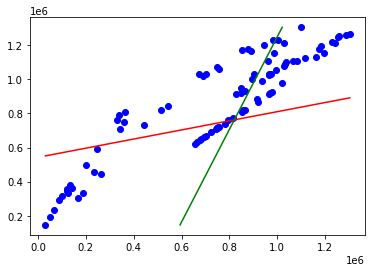

In [18]:
plt.scatter(x_sample, y_sample, color='blue')
k, b = get_regress_k_b(x_sample, y_sample)
x = np.array([np.min(x_sample), np.max(x_sample)])
y = k * x + b
plt.plot(x, y, color='red')

k, b = get_regress_k_b(y_sample, x_sample)
y = np.array([np.min(y_sample), np.max(y_sample)])
x = k * y + b
plt.plot(x, y, color='green')
plt.show()

Прямые линейной регресси достаточно плохо описывают множество точек двумерной выборки

### Вычислить корреляционные отношения $\boldsymbol\eta_\textbf{yx}$ и $\boldsymbol\eta_\textbf{xy}$. Убедиться, что неравенства $\boldsymbol\eta_\textbf{yx} > |\boldsymbol r_\textbf{yx}|$ и $\boldsymbol\eta_\textbf{xy} > |\boldsymbol r_\textbf{xy}|$ выполняются. Сделать выводы

In [19]:
def get_corr_ratio(fir_sample, sec_sample):
    counts = get_2d_inter_counts(fir_sample, sec_sample)
    fir_cond = get_cond_variant(fir_sample)
    sec_cond = get_cond_variant(sec_sample)
    fir_sums = np.sum(counts, axis=0)
    sec_sums = np.sum(counts, axis=1)
    n_mul_fir = fir_cond * fir_sums
    n_mul_sec = sec_cond * sec_sums
    mean_fir = get_mean(n_mul_fir)
    mean_sec = get_mean(n_mul_sec)
    general_std = np.sum(
        sec_sums * (sec_cond - get_mean(sec_cond)) ** 2 / len(fir_cond)
    ) ** (1/2)
    intergroup_std = np.sum(
        fir_sums * (sec_sums - mean_sec) ** 2 / len(fir_cond)
    ) ** (1/2)
    return intergroup_std / general_std

In [20]:
display(Math('\eta_{yx} ='
             f'{round(get_corr_ratio(x_sample, y_sample), disp_pres)}' + '; ' +
             '\eta_{xy} =' +
             f'{round(get_corr_ratio(y_sample, x_sample), disp_pres)}'))

display(Math(f'r_{{yx}} = {str(round(get_corr_coef(x_sample, y_sample), disp_pres))}' + '; ' +
             f'r_{{xy}} = {str(round(get_corr_coef(y_sample, x_sample), disp_pres))}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Для заданной выборки построить корреляционную кривую параболического вида $\boldsymbol{y=a+bx+cx^2}$. Отобразить полученную кривую на множестве выборки. Сделать выводы

Найдем такие $a, b, c$, чтобы они удовлетворяли $\sum_{i=1}^{n}{(a+bx_i+cx_i^2-y_i)^2} \rightarrow min$

Для этого найдем корени системы уравнений 
$$
\begin{cases}
    \frac{d}{da}\sum_{i=1}^{n}(a+bx_i+cx_i^2-y_i)^2 = 0\\
    \frac{d}{db}\sum_{i=1}^{n}(a+bx_i+cx_i^2-y_i)^2 = 0\\
    \frac{d}{dc}\sum_{i=1}^{n}(a+bx_i+cx_i^2-y_i)^2 = 0
\end{cases}\\
\begin{cases}
    \frac{d}{da}\sum_{i=1}^{n}(a^2 + 2 a b x_i + 2 a c x_i^2 - 2 a y_i + b^2 x_i^2 + 2 b c x_i^3 - 2 b x_i y_i + c^2 x_i^4 - 2 c x_i^2 y_i + y_i^2) = 0\\
    \frac{d}{db}\sum_{i=1}^{n}(a^2 + 2 a b x_i + 2 a c x_i^2 - 2 a y_i + b^2 x_i^2 + 2 b c x_i^3 - 2 b x_i y_i + c^2 x_i^4 - 2 c x_i^2 y_i + y_i^2) = 0\\
    \frac{d}{dc}\sum_{i=1}^{n}(a^2 + 2 a b x_i + 2 a c x_i^2 - 2 a y_i + b^2 x_i^2 + 2 b c x_i^3 - 2 b x_i y_i + c^2 x_i^4 - 2 c x_i^2 y_i + y_i^2) = 0
\end{cases}\\
\begin{cases}
    \sum_{i=1}^{n}(2 a + 2 b x_i + 2 c x_i^2 - 2 y_i) = 0\\
    \sum_{i=1}^{n}(2 a x_i + 2 b x_i^2 + 2 c x_i^3 - 2 x_i y_i) = 0\\
    \sum_{i=1}^{n}(2 a x_i^2 + 2 b x_i^3 + 2 c x_i^4 - 2 x_i^2 y_i) = 0
\end{cases}\\
\begin{cases}
    2 a n + 2 b \sum_{i=1}^{n}(x_i) + 2 c \sum_{i=1}^{n}(x_i^2) - 2 \sum_{i=1}^{n}(y_i) = 0\\
    2 a \sum_{i=1}^{n}(x_i) + 2 b \sum_{i=1}^{n}(x_i^2) + 2 c \sum_{i=1}^{n}(x_i^3) - 2 \sum_{i=1}^{n}(x_i y_i) = 0\\
    2 a \sum_{i=1}^{n}(x_i^2) + 2 b \sum_{i=1}^{n}(x_i^3) + 2 c \sum_{i=1}^{n}(x_i^4) - 2 \sum_{i=1}^{n}(x_i^2 y_i) = 0
\end{cases}\\
$$

In [21]:
#def get_parabol_coefs(x_sample, y_sample):
    

### Для заданной выборки построить нелинейные корреляционные кривые c помощью МНК в зависимости от номера варианта: $\boldsymbol{y = \alpha x^{\beta}}$

$y = \alpha x^{\beta} \Rightarrow ln(y) = ln(\alpha) + \beta \cdot \text{ln}(x)\\$
$\hat{y} = ln(y); \hat{x} = ln(x) \newline$
$\sum_{i=1}^{n}{(ln(\alpha) + \beta \cdot \hat{x_i} - \hat{y_i})^2} \rightarrow min \newline$
$ln(\alpha) = \frac{\overline{xy} - \overline{x} \cdot \overline{y}}{\overline{x^2} - (\overline{x})^2} \newline$
$\beta = \frac{\overline{x^2} \cdot \overline{y} - \overline{x} \cdot \overline{xy}}{\overline{x^2} - (\overline{x})^2} \newline$

1.0027466222170769 10.3408


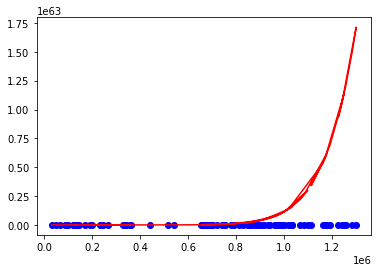

In [22]:
u = get_cond_variant(x_sample), 
v = get_cond_variant(y_sample)
y_x_counts = get_2d_inter_counts(x_sample, y_sample)
x_sums = np.sum(y_x_counts, axis=0)
y_sums = np.sum(y_x_counts, axis=1)
nu_sums = u * x_sums
nv_sums = v * y_sums

xy_ = np.sum(y_x_counts * get_cond_variant(x_sample) * 
               get_cond_variant(y_sample))
alpha = np.exp(
    (xy_ - get_mean(nu_sums) * get_mean(nv_sums)) / \
    (get_mean(nu_sums ** 2) - get_mean(nu_sums) ** 2)
)
beta = (get_mean(nu_sums ** 2) * get_mean(nv_sums) - get_mean(nu_sums) * xy_) /\
    (get_mean(nu_sums ** 2) - get_mean(nu_sums) ** 2)
y = alpha * x_sample ** beta
print(alpha, beta)

plt.scatter(x_sample, y_sample, color='blue')
plt.plot(x_sample, y, color='red')
plt.show()

Видимо, где-то ошибка...

## Выводы


В ходе работы был найден коэффициент корреляции между двумя выборками, доверительные интервалы для него при 𝛾 ∈ {0.95, 0.99}, проверена стат. гипотезы о равенстве его нулю. Были построены уравнения средней квадратичной регрессии, вычислены корреляционные отношения, 